This demo starts with reading in raw single-cell RNA seq data and walks through the pre-processing steps. The bulk ATAC data here has been preprocessed (differential peak accessibility through DESeq2) and the input is a set of differential-accessible peaks across all clusters. Alternatively, for scATACseq data, either differential accessibility can be run with e.x. Fisher's exact test, or simply take the most open peaks in a given cluster.

In [1]:
import pandas as pd
import numpy as np
import scanpy
import pickle
from tqdm import tqdm
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Colors for each cluster
# This palette can be custom made
palette= {2: "#b0799a", 
          7: "#9d9cd5", 
          10: "#e69b00", 
          12: "#8eb87f"}

In [5]:
import os
current_dir=os.getcwd()
output_dir=current_dir+'/outputs'
# We have included the data in this notebook as a .gzip file, please unzip first
data_dir=current_dir+'/demo/demo_data/regeneration_data'

# Reading in Data

In [6]:
normal_peaks=pd.read_csv(data_dir+"/regeneration_differential_peaks.bed", sep='\t', header=None)[[0,1,2]]
normal_peaks.columns = ['chrom','chromStart','chromEnd']
width=normal_peaks['chromEnd']-normal_peaks['chromStart']
normal_peaks=normal_peaks.iloc[np.where(width<2000)]
normal_peaks

,chrom,chromStart,chromEnd
2,chr7,12774451,12775054
3,chr2,85093270,85094452
4,chr15,100699353,100699836
5,chr12,40224231,40225080
6,chr10,75495308,75496340
...,...,...,...
7623,chr19,28037074,28037660
7624,chrX,7420885,7421558
7625,chr1,88357474,88358386
7626,chr4,116167350,116167892


In [7]:
# read in scRNAseq data
# we have already normalized to median library size
# we have alos 
X = scanpy.read_h5ad(data_dir+"/regeneration_adata_normalized.h5ad")
X

AnnData object with n_obs × n_vars = 5501 × 16826
    obs: 'batch', 'total_molecules', 'condition', 'cluster'
    obsm: 'X_EMBED', 'X_PCA', 'X_fdl'

In [8]:
# make sure all the columns are nonzero!! This is very important for constraints
nonzero_columns=np.where(~np.all(X.X.toarray() == 0, axis = 0))[0]
X = X[:,nonzero_columns]
X.layers['norm_counts'] = X.X.copy()

In [9]:
X.obsm['X_pca']=X.obsm['X_PCA']
# will require data to have finished preprocessing before inputting for the package
# log transform data
scanpy.pp.log1p(X)

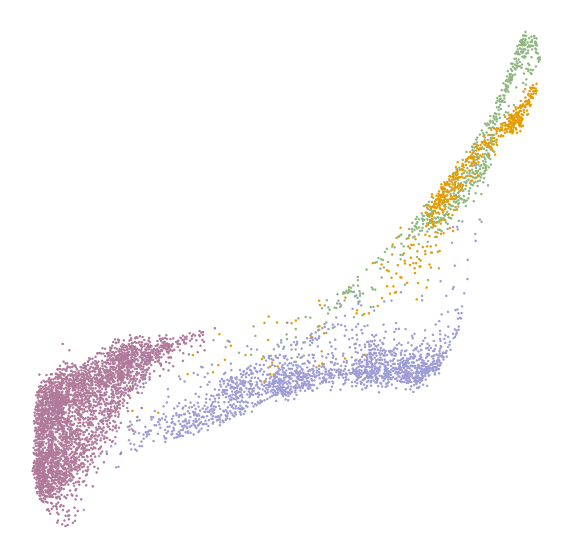

In [10]:
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(X.obsm['X_fdl'][:,0],X.obsm['X_fdl'][:,1],s=2,c=[palette[i] for i in X.obs['cluster'].to_list()])
ax.set_axis_off()

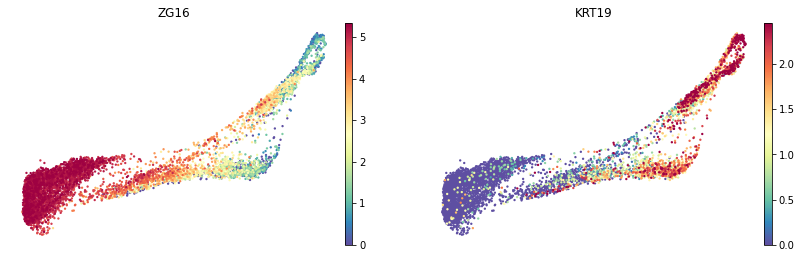

In [11]:
# Plotting known canonical markers
scanpy.pl.embedding(X, basis='X_fdl', color=['ZG16', 'KRT19'], 
                    vmin = 'p5', vmax = 'p95', frameon=False, cmap='Spectral_r')

# Building GRN

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from sckinetics import tf_targets
from sckinetics import atac_processing_utils

In [19]:
#full wrapper to:
    #install R packages, if not installed
    #download and load genome into memory
    #load motif files
peak_annotation = tf_targets.PeakAnnotation(adata=X,genome='mm10')

Starting peak annotation. Make sure the X matrix in adata has been log transformed.
Checking R packages are installed ...
 
Finished setting up R packages
Loading genome (this make take a while!) ...


Loading chromosomes for genome mm10:   0%|               | 0/22 [00:00<?, ?it/s]

Loading motifs ...


In [20]:
#full wrapper to:
    #motif calling
    #peak annotation
    #compute background
    #scan peaks
    #format TF-target pairs
peak_annotation.call_motifs(normal_peaks,pvalue=1e-10)

Calling motifs with default settings...
Annotating peaks
Running ChIPSeeker ...
>> preparing features information...		 2023-01-25 03:05:37 PM 
>> identifying nearest features...		 2023-01-25 03:05:38 PM 
>> calculating distance from peak to TSS...	 2023-01-25 03:05:40 PM 
>> assigning genomic annotation...		 2023-01-25 03:05:40 PM 
>> assigning chromosome lengths			 2023-01-25 03:06:00 PM 
>> done...					 2023-01-25 03:06:00 PM 
Converting gene annotations ...
Filtering genes ...
Extracting peak sequence...
1431
Computing background...


  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

  0%|          | 0/358 [00:00<?, ?it/s]

Scanning peaks...
 Peak 357 in fourth quantileFinished peak scanning. Compiling all data (this might take a while!!)

Filtering genes...
Formatting pairs... (this might take a while!)

Finished motif calling.


In [21]:
cluster_basis='cluster'

In [22]:
#if running for distinct cell types, iterate over cell -type marker peaks
#input to velocity algorithm should require dictionary of G matrices indexed by cluster annotation
G_clusters = {}
for this_cluster in tqdm(list(set(X.obs[cluster_basis]))):
    #computes G for each cluster, which is a dictionary storing a target annotation
    #each target's TFs can be accessed as G[target_name].transcription_factors
    #indices in the count matrix are stored in G[target_name].target_index, and .transcription_factors_index
    #the corresponding imputed, scaled count matrix is added to peak_annotation.adata.obsm as "X_cluster"
    #cluster_peaks_filtered = np.intersect1d(peak_annotation.pairs.index,cluster_peaks[cluster])
    G_clusters[this_cluster] = peak_annotation.prepare_target_annotations(cluster_key=cluster_basis,
                                                                    cluster=this_cluster)
    
    
    #peak_annotation.adata.uns['X_HSC] -> X_

  0%|                                                     | 0/4 [00:00<?, ?it/s]

Starting MAGIC imputation


100%|█████████████████████████████████████████████| 4/4 [06:36<00:00, 99.12s/it]


In [23]:
# Saving everything we need for EM
pickle.dump(peak_annotation.adata, open(output_dir+"/adata_prepared.h5ad", 'wb'))
pickle.dump(G_clusters,open(output_dir+"/G.dict",'wb'))

In [25]:
# Reading in data for EM
adata = pickle.load(open(output_dir+"/adata_prepared.h5ad",'rb'))
G_clusters=pickle.load(open(output_dir+"/G.dict", 'rb'))

# EM

In [28]:
from sckinetics import EM

model = EM.ExpectationMaximization(threads=15, maxiter=20)
model.fit(adata, G_clusters, celltype_basis = "cluster")

Successfully initiated EM model.
Number of CPUs: 128.
Running on 15 threads.
Total number of cells: 5501
Cell types: 10, 2, 12, 7
Start calculating priors.
Getting priors for: 10
Getting priors for: 2
Getting priors for: 12
Getting priors for: 7
Start calculating constraints.
5500
Finished getting all constraints.
Running main EM algorithm for for: 10
Total number of targets: 1337


Celltype 10 on 15 batches:   0%|          | 0/15 [00:00<?, ?it/s]

Running main EM algorithm for for: 2
Total number of targets: 1337


Celltype 2 on 15 batches:   0%|          | 0/15 [00:00<?, ?it/s]

Running main EM algorithm for for: 12
Total number of targets: 1337


Celltype 12 on 15 batches:   0%|          | 0/15 [00:00<?, ?it/s]

Running main EM algorithm for for: 7
Total number of targets: 1337


Celltype 7 on 15 batches:   0%|          | 0/15 [00:00<?, ?it/s]

Finished ATACVelo calculation in 4673.289900302887 seconds.


In [29]:
pickle.dump(model,open(output_dir+"/model_0101.pickle",'wb'))
pickle.dump(adata,open(output_dir+"/adata_0101.pickle",'wb'))

# Plotting visualizations

In [61]:
from sckinetics import graph_embedding
from sckinetics import VelocityGraph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
embedding=adata.obsm['X_fdl']

vg = VelocityGraph(model, adata, knn=30)
vg.create_velocity_graph()
vg.compute_transitions()
velocity_embedding = vg.embed_graph(embedding)

Make sure that the model had already been fitted!


OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.


  0%|          | 0/5501 [00:00<?, ?it/s]

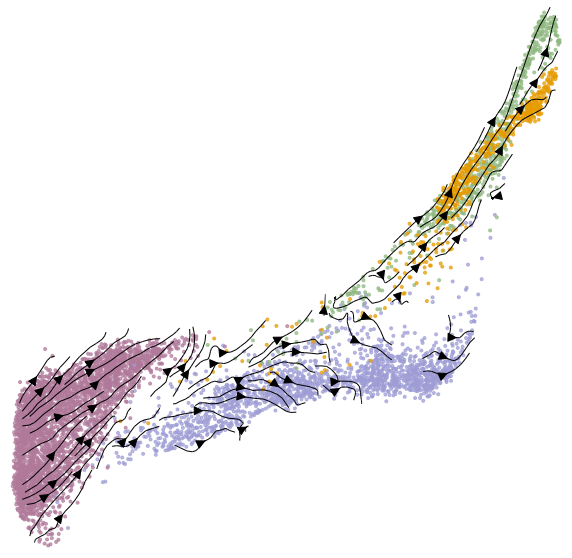

In [36]:
%matplotlib inline
celltypes_colors=[palette[i] for i in adata.obs['cluster']]
fig=graph_embedding.embedding_stream(embedding,velocity_embedding,density=2.5, 
                arrowsize=2, s=9, linewidth=1, cluster_color=celltypes_colors)

# TF_ablation experiment

In [67]:
from sckinetics import tf_perturbation

In [65]:
perturbation_scores=tf_perturbation.percell_ablate(model, adata, celltype_basis='cluster')

Calculating TF ablation on cluster 10


100%|█████████████████████████████████████████| 585/585 [03:37<00:00,  2.69it/s]


Calculating TF ablation on cluster 2


100%|█████████████████████████████████████████| 585/585 [10:49<00:00,  1.11s/it]


Calculating TF ablation on cluster 12


100%|█████████████████████████████████████████| 585/585 [06:13<00:00,  1.57it/s]


Calculating TF ablation on cluster 7


100%|█████████████████████████████████████████| 585/585 [10:29<00:00,  1.08s/it]


In [66]:
perturbation_scores

,AC168977.1,AHCTF1,AHR,AIRE,ALX4,AR,ARID2,ARID3A,ARID3B,ARID5A,...,ZIC5,ZIK1,ZKSCAN1,ZKSCAN17,ZKSCAN5,ZKSCAN6,ZSCAN20,ZSCAN26,ZSCAN29,ZZZ3
120726911604597_DACD403_Kate_plus,4.105881e-06,2.720557e-06,0.000009,4.355122e-06,4.836087e-06,4.880587e-06,3.664581e-06,5.022569e-06,4.308557e-06,0.000004,...,3.945166e-06,4.837223e-06,3.315594e-06,1.064640e-06,4.352363e-06,1.334016e-06,3.866467e-06,2.930722e-06,4.153683e-06,5.891655e-06
120726924421470_DACD403_Kate_plus,7.767745e-07,8.183501e-07,0.000074,7.151005e-07,7.289138e-07,7.127051e-07,2.562786e-07,5.949266e-07,7.538356e-07,0.000004,...,8.276060e-07,7.204664e-07,1.743911e-07,7.743595e-07,8.629358e-07,2.118124e-07,5.898196e-07,7.446128e-07,3.560497e-07,1.722444e-07
120726943643565_DACD403_Kate_plus,1.639159e-06,1.170603e-06,0.000005,1.581361e-06,1.767829e-06,1.784897e-06,2.545172e-06,1.881880e-06,1.824195e-06,0.000002,...,1.601958e-06,1.770825e-06,1.599640e-06,6.870257e-07,1.488416e-06,5.928891e-07,1.510950e-06,1.411261e-06,1.759400e-06,1.572205e-06
120772949069163_DACD403_Kate_plus,2.628066e-06,2.158539e-06,0.000041,2.929011e-06,2.697841e-06,2.824922e-06,1.149749e-06,2.981115e-06,1.931057e-06,0.000022,...,1.885857e-06,2.916188e-06,2.637932e-06,1.113297e-06,5.057239e-06,1.615559e-06,2.501049e-06,1.399266e-06,2.390651e-06,1.230993e-06
120864470060462_DACD403_Kate_plus,6.093181e-06,3.911509e-06,0.000011,6.675726e-06,7.365297e-06,7.427297e-06,4.302477e-06,7.564417e-06,6.264698e-06,0.000006,...,5.880166e-06,7.362305e-06,4.522398e-06,1.550216e-06,6.801243e-06,1.992059e-06,5.811116e-06,4.029100e-06,5.978629e-06,1.106857e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241106389429605_DACD550_kate_plus,1.200061e-05,2.995998e-06,0.000010,9.007477e-06,1.197104e-05,1.207899e-05,1.276512e-06,6.013524e-06,8.382041e-06,0.000004,...,1.101130e-05,1.287316e-05,4.628697e-06,4.229344e-06,1.118118e-05,8.190734e-06,1.190903e-05,6.573630e-06,1.943753e-05,4.500824e-06
241106402626286_DACD550_kate_plus,1.160167e-05,2.950156e-06,0.000010,8.709063e-06,1.155423e-05,1.167407e-05,1.207390e-06,5.838073e-06,8.107709e-06,0.000004,...,1.066829e-05,1.244412e-05,4.522827e-06,4.090931e-06,1.081956e-05,7.933952e-06,1.150215e-05,6.431211e-06,1.870826e-05,4.422412e-06
241114562127587_DACD550_kate_plus,1.146746e-05,2.933279e-06,0.000009,8.608296e-06,1.141582e-05,1.152044e-05,1.188333e-06,5.777838e-06,7.991337e-06,0.000004,...,1.055132e-05,1.230014e-05,4.476554e-06,4.052313e-06,1.073381e-05,7.903267e-06,1.136587e-05,6.362528e-06,1.860866e-05,4.394751e-06
241114607893403_DACD550_kate_plus,1.154972e-05,2.946858e-06,0.000010,8.670231e-06,1.150120e-05,1.161128e-05,1.202818e-06,5.813989e-06,8.109693e-06,0.000004,...,1.062146e-05,1.238870e-05,4.500260e-06,4.089999e-06,1.078131e-05,7.900342e-06,1.145000e-05,6.401381e-06,1.861867e-05,4.416396e-06
